## NLP Class Final Project
### Part 3 - Sentiment Analysis

Author: Aashish Singh

In [1]:
import os
import time
import math
import re
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

from collections import Counter
import wordcloud

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
import spacy

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import warnings

warnings.simplefilter('once')
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

/Users/aashishsingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/aashishsingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nl

True

In [2]:
import multiprocessing
from pandarallel import pandarallel
num_processors = multiprocessing.cpu_count()
num_processors
workers = num_processors-1
pandarallel.initialize(nb_workers=multiprocessing.cpu_count()-1, use_memory_fs=False)
print(f'Using {workers} workers')

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Using 11 workers


In [3]:
%%time

news_processed = pd.read_parquet('~/Downloads/news_processed.parquet')
news_processed.shape 

CPU times: user 30 s, sys: 33.7 s, total: 1min 3s
Wall time: 48.3 s


(120177, 17)

In [4]:
# Sample 50% of data to run the notebook (remove during final run)
news_processed = news_processed.sample(frac=0.5, random_state=123)
news_processed.shape

(54080, 17)

In [5]:
news_processed.head(5)

,url,date,language,title,text,year,month,day,text_ner,title_ner,text_cleaned,title_cleaned,text_lemmatized,title_lemmatized,text_tokenized,title_tokenized,text_word_count
101390,https://www.fool.com/investing/2023/09/01/ai-stock-thats-screaming-bargain-you-should-buy/?source=eptyholnk0000202&utm_source=yahoo-host&utm_medium=feed&utm_campaign=article&yptr=yahoo?src=rss,2023-09-01,en,1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool,\n\n1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool\nPlease ensure Javascript is enabled for purposes of website accessibility\n\nSearch\n\nAccessibility\nLog In\n\nHelp\n\n\nJoin The Motley Fool\nAccessibility Menu\n\nOur Services\nInvesting Basics\n\nangle-down\n\nPremium Services\n\n\nStock Advisor\nOur Flagship Service\n\n\nReturn\n509%\n\n\nS&P Return\n132%\n\nRule Breakers\nHigh-growth Stocks\n\n\nReturn\n241%\n\n\nS&P Return\n111%\nRetur...,2023,9,1,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool Please ensure Javascript is enabled for purposes of website accessibility Search Accessibility Log In Help Join The Motley Fool Accessibility Menu Our Services Investing Basics angle down Premium Services Stock Advisor Our Flagship Service Return S P Return Rule Breakers High growth Stocks Return S P Return Returns as of View Our Services Investing How to Invest Money What to Invest In How to Invest i...,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purposes website accessibility search accessibility log help join motley fool accessibility menu services investing basics angle premium services stock advisor flagship service return return rule breakers high growth stocks return return returns view services investing invest money invest invest stocks invest index funds invest etfs invest real estate financial dictionary best accounts best stock brok...,ai stock screaming bargain buy hand fist right motley fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purpose website accessibility search accessibility log help join motley fool accessibility menu service investing basic angle premium service stock advisor flagship service return return rule breaker high growth stock return return return view service investing invest money invest invest stock invest index fund invest etf invest real estate financial dictionary best account best stock broker best brok...,ai stock screaming bargain buy hand fist right motley fool,"[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool, please, ensure, javascript, enabled, purpose, website, accessibility, search, accessibility, log, help, join, motley, fool, accessibility, menu, service, investing, basic, angle, premium, service, stock, advisor, flagship, service, return, return, rule, breaker, high, growth, stock, return, return, return, view, service, investing, invest, money, invest, invest, stock, invest, index, fund, invest, etf, invest, real, estate...","[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool]",1475
58707,https://www.zmescience.com/science/news-science/chinese-communist-party-wants-to-use-an-ai-algorithm-to-read-minds-and-test-the-loyalty-of-its-members/,2022-07-20,en,"Chinese Communist Party wants to use an AI algorithm to ""read minds"" and test the loyalty of its members","\n\nChinese Communist Party wants to use an AI algorithm to ""read minds"" and test the loyalty of its members\n \n \nNews\n\nEnvironment\n\nHealth\n\nFuture\n\nSpace\n\nFeatures\n\nMore\n\nAbout\nThe Team\nAdvertise\nContribute\nOur stance on climate change\nPrivacy Policy\nContact\n No Result \n\n View All Result \n \n \n\n \n \n\n No Result \n\n View All Result \n \n\n\n \n\n \n\n \n\n \n\n No Result \n\n View All Result \n \n\n \n\

### 1. Sentiment Analysis - Utilize Vader

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
%%time

def sentiment_score(x):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(x)

news_sentiment = news_processed['text_cleaned'].parallel_apply(sentiment_score)
news_sentiment_df = pd.DataFrame(news_sentiment.tolist())

CPU times: user 631 ms, sys: 1.72 s, total: 2.35 s
Wall time: 11min 46s


In [8]:
news_sentiment_df

,neg,neu,pos,compound
0,0.070,0.629,0.301,0.9999
1,0.055,0.706,0.239,0.9992
2,0.022,0.838,0.139,0.9955
3,0.028,0.771,0.201,0.9952
4,0.040,0.823,0.137,0.9981
...,...,...,...,...
54075,0.095,0.774,0.131,0.9786
54076,0.005,0.846,0.149,0.9983
54077,0.045,0.706,0.249,0.9995
54078,0.037,0.824,0.139,0.9987


In [9]:
%%time

# Define a function to interpret the compound score as Positive or Negative
def label_sentiment(row):
    if row['compound'] > 0:
        return 'positive'
    elif row['compound'] < 0:
        return 'negative'
    else:
        return 'neutral'

news_sentiment_df['sentiment'] = news_sentiment_df.parallel_apply(label_sentiment, axis=1)

CPU times: user 36 ms, sys: 335 ms, total: 371 ms
Wall time: 502 ms


In [10]:
news_sentiment_df['sentiment'].value_counts()

sentiment
positive    51176
negative     2895
neutral         9
Name: count, dtype: int64

In [11]:
news_processed = news_processed.set_index(news_sentiment_df.index)

In [12]:
news_processed['vader_sentiment'] = news_sentiment_df['sentiment']
news_processed['vader_compound'] = news_sentiment_df['compound']
news_processed['vader_positive'] = news_sentiment_df['pos']
news_processed['vader_negative'] = news_sentiment_df['neg']

In [13]:
news_processed['vader_sentiment'].value_counts()

vader_sentiment
positive    51176
negative     2895
neutral         9
Name: count, dtype: int64

In [14]:
news_processed[news_processed['vader_sentiment'] == 'positive'][[
    'title_cleaned', 'text_cleaned', 'vader_sentiment', 'vader_compound', 'vader_positive'
]].sort_values(by='vader_positive', ascending=False).head(5)

,title_cleaned,text_cleaned,vader_sentiment,vader_compound,vader_positive
15018,revolutionizing ai security sai kiran vision intelligence,revolutionizing ai security sai kiran vision intelligence free press journal paper get app home mumbai newsfpj film newsmovie reviewsbusinesstech ai security sai kiran vision intelligence revolutionizing ai security sai kiran vision intelligence fast paced realm artificial intelligence story sai kiran founder ceo intelligence stands hailing bangalore sai kiran leading ambitious project enhance ai driven security solutions india rahul mupdated monday june pm ist revolutionizing ai security sa...,positive,0.9999,0.431
52373,artificial intelligence security market components competitive landscape market forecast technology type murphy hockey law,artificial intelligence security market components competitive landscape market forecast technology type murphy hockey law skip content search murphy hockey law menu contact search search close search close menu contact categories news artificial intelligence security market components competitive landscape market forecast technology type post author post date august global artificial intelligence security market report provides critical insights global industry also contains newfangled info...,positive,0.9999,0.427
47688,ai tools like chatgpt increasingly used job searches money,ai tools like chatgpt increasingly used job searches money close credit money best news guides best credit repair companies best identity theft protection services best credit monitoring services insurance money best news guides best long term care insurance best pet insurance best life insurance best travel insurance best rv insurance best dental insurance best motorcycle insurance best car insurance best homeowners insurance best health insurance loans money best news guides best personal ...,positive,1.0000,0.425
7503,artificial intelligence security market applications challenges growth shares trends forecast packaging news,artificial intelligence security market applications challenges growth shares trends forecast packaging news skip content thursday april us team contact us privacy policy packaging news packaging market research reports home industry report market report industry analytics market analytics market outlook market research future demands market study opportunities forecast intelligence security market applications challenges growth shares trends forecast artificial intelligence security market ...,positive,0.9999,0.417
25608,seven steps establishing innovation culture ai data services companies,seven steps establishing innovation culture ai data services companiessubscribe sign inbetathis beta experience may opt clicking heremore forbesmay edtspace cybersecurity next frontier small business growthmay edtmanaging data artificial intelligence digital prescription life sciences industrymay edtfive keys gain maintain saas customer loyaltymay edtthree reasons need better fix unhealthy indoor airmay edthow chris howard fuel capital broke ranks world best seed investorsmay edtwhy companie...,positive,0.9999,0.416


In [15]:
news_processed[news_processed['vader_sentiment'] == 'negative'][[
    'title_cleaned', 'text_cleaned', 'vader_sentiment', 'vader_compound', 'vader_negative'
]].sort_values(by='vader_negative', ascending=False).head(5)

,title_cleaned,text_cleaned,vader_sentiment,vader_compound,vader_negative
44437,safetylit identifying suicide attempter major depressive disorder machine learning importance pain avoidance event related potential features affective processing,safetylit identifying suicide attempter major depressive disorder machine learning importance pain avoidance event related potential features affective processing home search boolean search thesaurus sources authors weekly updates update bulletin pdf update bulletin web us safetylit aa aa aa safetylit weekly update compile citations summaries new articles every week rss feed help tutorials faq contact us contact info safetylit service search results journal article identifying suicide attemp...,negative,-0.9987,0.345
19188,james bulger mother condemns disgusting ai clips tiktok murdered son newschain,james bulger mother condemns disgusting ai clips tiktok murdered son newschain watch today stop sportwomen sport sportwomen sportarchiveabout uspopular videosmore news july bulger mother condemns disgusting ai clips tiktok murdered sonby july mother murdered two year old james bulger condemned sick ai generated clips son circulating social media three decades animated version dead toddler discussed abduction murder two year old boys videos shared tiktok james mother denise fergus condemned d...,negative,-0.9990,0.308
48227,mind machine chilling ai predicts nuclear war would look like attacks london moscow washington savage nation,mind machine chilling ai predicts nuclear war would look like attacks london moscow washington savage nation skip content top menu home podcast listen sponsor savage photos savage eye camera teddy corner savage newsletter main menu mind machine chilling ai predicts nuclear war would look like attacks london moscow washington share facebooktweet twitter sun artificial intelligence offered horrifying vision world faces nuclear armageddon world war responding prompts nuclear bomb war apocalypse...,negative,-0.9976,0.305
53893,safetylit bored death artificial intelligence research reveals role boredom suicide behavior,safetylit bored death artificial intelligence research reveals role boredom suicide behavior home search boolean search thesaurus sources authors weekly updates update bulletin pdf update bulletin web us safetylit aa aa aa safetylit weekly update compile citations summaries new articles every week rss feed help tutorials faq contact us contact info safetylit service search results journal article bored death artificial intelligence research reveals role boredom suicide behavior citation liss...,negative,-0.9984,0.297
12196,terrifying rise ai slaughterbots programmed kill experts warn robot apocalypse banned,terrifying rise ai slaughterbots programmed kill experts warn robot apocalypse banned nowjump directly contentsign inscottish sun us editionuk editionirish sunsun bingodream teamsearchhomeplay zsun bingosun vouchersall footballall newsscottish newsworld newsnewsworld newsrobogeddon terrifying rise ai slaughterbots programmed kill experts warn robot apocalypse banned felix dec dec superpower arms race build killer robots could wipe humanity left unchecked experts fear doomsday warning comes u...,negative,-0.9997,0.279


In [16]:
news_processed.head(5)

,url,date,language,title,text,year,month,day,text_ner,title_ner,text_cleaned,title_cleaned,text_lemmatized,title_lemmatized,text_tokenized,title_tokenized,text_word_count,vader_sentiment,vader_compound,vader_positive,vader_negative
0,https://www.fool.com/investing/2023/09/01/ai-stock-thats-screaming-bargain-you-should-buy/?source=eptyholnk0000202&utm_source=yahoo-host&utm_medium=feed&utm_campaign=article&yptr=yahoo?src=rss,2023-09-01,en,1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool,\n\n1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool\nPlease ensure Javascript is enabled for purposes of website accessibility\n\nSearch\n\nAccessibility\nLog In\n\nHelp\n\n\nJoin The Motley Fool\nAccessibility Menu\n\nOur Services\nInvesting Basics\n\nangle-down\n\nPremium Services\n\n\nStock Advisor\nOur Flagship Service\n\n\nReturn\n509%\n\n\nS&P Return\n132%\n\nRule Breakers\nHigh-growth Stocks\n\n\nReturn\n241%\n\n\nS&P Return\n111%\nRetur...,2023,9,1,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool Please ensure Javascript is enabled for purposes of website accessibility Search Accessibility Log In Help Join The Motley Fool Accessibility Menu Our Services Investing Basics angle down Premium Services Stock Advisor Our Flagship Service Return S P Return Rule Breakers High growth Stocks Return S P Return Returns as of View Our Services Investing How to Invest Money What to Invest In How to Invest i...,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purposes website accessibility search accessibility log help join motley fool accessibility menu services investing basics angle premium services stock advisor flagship service return return rule breakers high growth stocks return return returns view services investing invest money invest invest stocks invest index funds invest etfs invest real estate financial dictionary best accounts best stock brok...,ai stock screaming bargain buy hand fist right motley fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purpose website accessibility search accessibility log help join motley fool accessibility menu service investing basic angle premium service stock advisor flagship service return return rule breaker high growth stock return return return view service investing invest money invest invest stock invest index fund invest etf invest real estate financial dictionary best account best stock broker best brok...,ai stock screaming bargain buy hand fist right motley fool,"[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool, please, ensure, javascript, enabled, purpose, website, accessibility, search, accessibility, log, help, join, motley, fool, accessibility, menu, service, investing, basic, angle, premium, service, stock, advisor, flagship, service, return, return, rule, breaker, high, growth, stock, return, return, return, view, service, investing, invest, money, invest, invest, stock, invest, index, fund, invest, etf, invest, real, estate...","[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool]",1475,positive,0.9999,0.301,0.070
1,https://www.zmescience.com/science/news-science/chinese-communist-party-wants-to-use-an-ai-algorithm-to-read-minds-and-test-the-loyalty-of-its-members/,2022-07-20,en,"Chinese Communist Party wants to use an AI algorithm to ""read minds"" and test the loyalty of its members","\n\nChinese Communist Party wants to use an AI algorithm to ""read minds"" and test the loyalty of its members\n \n \nNews\n\nEnvironment\n\nHealth\n\nFuture\n\nSpace\n\nFeatures\n\nMore\n\nAbout\nThe Team\nAdvertise\nContribute\nOur stance on climate change\nPrivacy Policy\nContact\n No Result \n\n View All Result \n \n \n\n \n \n\n No Result \n\n View All

In [17]:
news_processed['year_month'] = news_processed['year'].astype(str).str.zfill(2) + '-' + news_processed['month'].astype(str).str.zfill(2)

In [18]:
# Group by year and month, and calculate the average sentiment score for each month
monthly_sentiment = news_processed.groupby(['year_month'])[['vader_compound', 
                                                            'vader_positive', 
                                                            'vader_negative']].mean().reset_index()

monthly_sentiment.columns = ['year_month', 
                             'average_vader_sentiment_score',
                             'average_vader_positive_score',
                             'average_vader_negative_score']


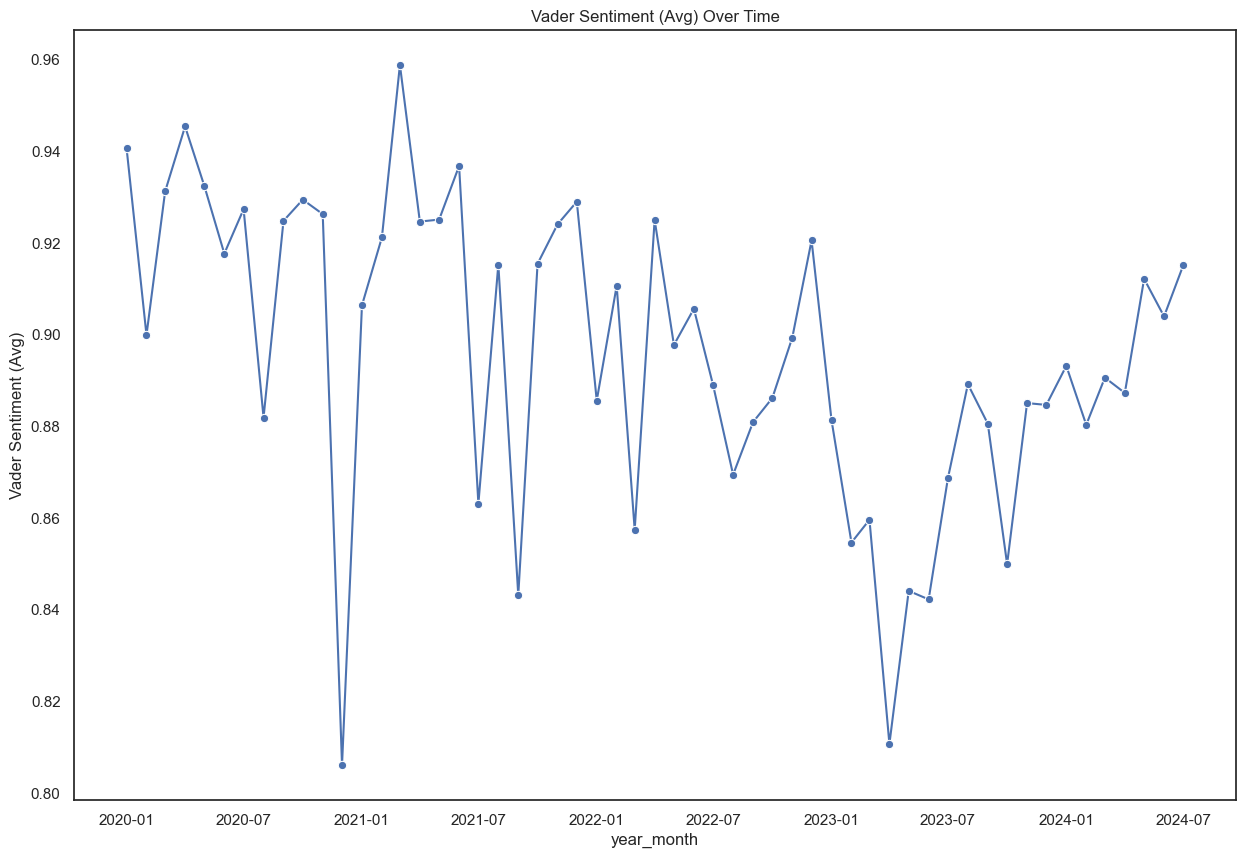

In [19]:
monthly_sentiment['year_month'] = pd.to_datetime(monthly_sentiment['year_month'])
sns.set(style="white")

plt.figure(figsize=(15, 10))
sns.lineplot(data=monthly_sentiment, x='year_month', y='average_vader_sentiment_score', marker='o')
plt.title('Vader Sentiment (Avg) Over Time', fontsize=12)
plt.ylabel('Vader Sentiment (Avg)', fontsize=12)
plt.show()

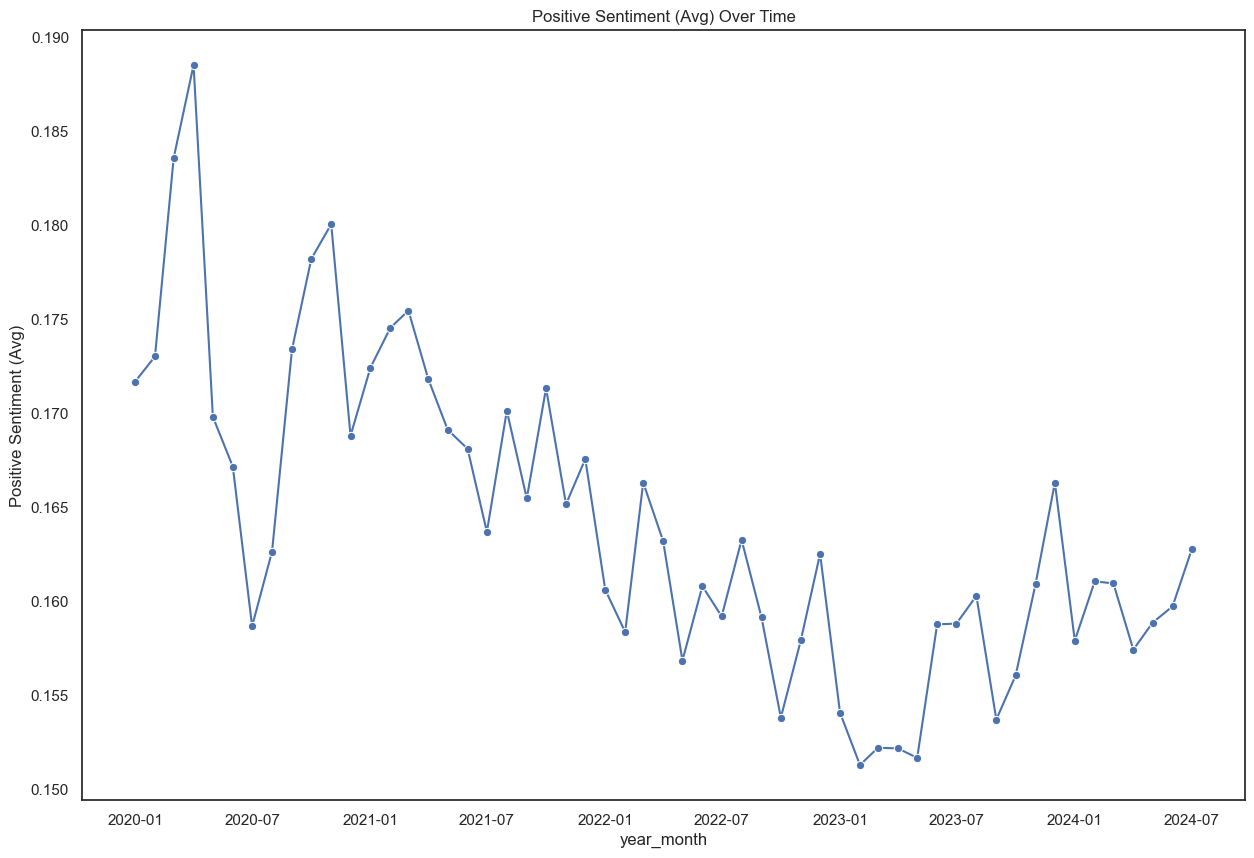

In [20]:
monthly_sentiment['year_month'] = pd.to_datetime(monthly_sentiment['year_month'])
sns.set(style="white")

plt.figure(figsize=(15, 10))
sns.lineplot(data=monthly_sentiment, x='year_month', y='average_vader_positive_score', marker='o')
plt.title('Positive Sentiment (Avg) Over Time', fontsize=12)
plt.ylabel('Positive Sentiment (Avg)', fontsize=12)
plt.show()

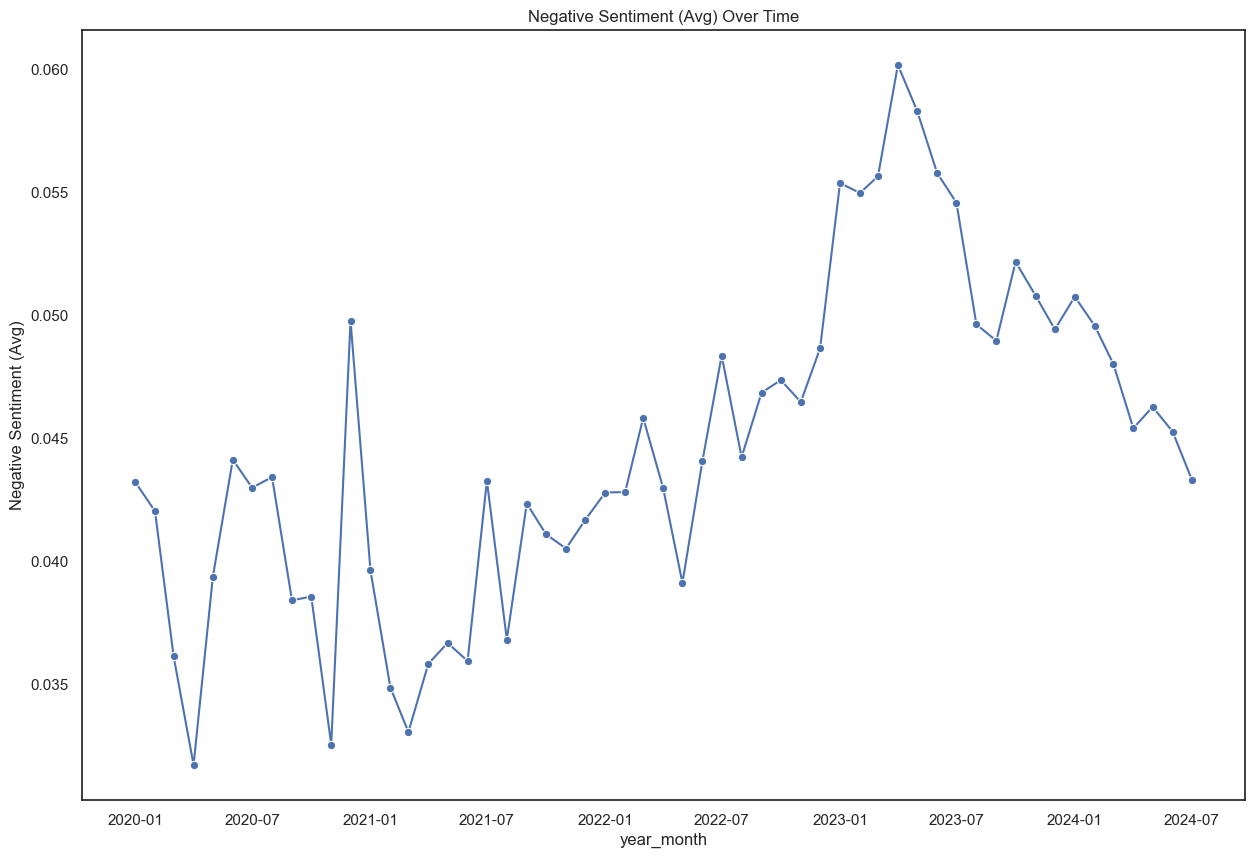

In [21]:
monthly_sentiment['year_month'] = pd.to_datetime(monthly_sentiment['year_month'])
sns.set(style="white")

plt.figure(figsize=(15, 10))
sns.lineplot(data=monthly_sentiment, x='year_month', y='average_vader_negative_score', marker='o')
plt.title('Negative Sentiment (Avg) Over Time', fontsize=12)
plt.ylabel('Negative Sentiment (Avg)', fontsize=12)
plt.show()

### 2. NER - Attach entities with sentiment

In [22]:
news_processed.head(10)

,url,date,language,title,text,year,month,day,text_ner,title_ner,text_cleaned,title_cleaned,text_lemmatized,title_lemmatized,text_tokenized,title_tokenized,text_word_count,vader_sentiment,vader_compound,vader_positive,vader_negative,year_month
0,https://www.fool.com/investing/2023/09/01/ai-stock-thats-screaming-bargain-you-should-buy/?source=eptyholnk0000202&utm_source=yahoo-host&utm_medium=feed&utm_campaign=article&yptr=yahoo?src=rss,2023-09-01,en,1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool,\n\n1 AI Stock That's a Screaming Bargain You Should Buy Hand Over Fist Right Now | The Motley Fool\nPlease ensure Javascript is enabled for purposes of website accessibility\n\nSearch\n\nAccessibility\nLog In\n\nHelp\n\n\nJoin The Motley Fool\nAccessibility Menu\n\nOur Services\nInvesting Basics\n\nangle-down\n\nPremium Services\n\n\nStock Advisor\nOur Flagship Service\n\n\nReturn\n509%\n\n\nS&P Return\n132%\n\nRule Breakers\nHigh-growth Stocks\n\n\nReturn\n241%\n\n\nS&P Return\n111%\nRetur...,2023,9,1,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool Please ensure Javascript is enabled for purposes of website accessibility Search Accessibility Log In Help Join The Motley Fool Accessibility Menu Our Services Investing Basics angle down Premium Services Stock Advisor Our Flagship Service Return S P Return Rule Breakers High growth Stocks Return S P Return Returns as of View Our Services Investing How to Invest Money What to Invest In How to Invest i...,AI Stock That s a Screaming Bargain You Should Buy Hand Over Fist Right Now The Motley Fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purposes website accessibility search accessibility log help join motley fool accessibility menu services investing basics angle premium services stock advisor flagship service return return rule breakers high growth stocks return return returns view services investing invest money invest invest stocks invest index funds invest etfs invest real estate financial dictionary best accounts best stock brok...,ai stock screaming bargain buy hand fist right motley fool,ai stock screaming bargain buy hand fist right motley fool please ensure javascript enabled purpose website accessibility search accessibility log help join motley fool accessibility menu service investing basic angle premium service stock advisor flagship service return return rule breaker high growth stock return return return view service investing invest money invest invest stock invest index fund invest etf invest real estate financial dictionary best account best stock broker best brok...,ai stock screaming bargain buy hand fist right motley fool,"[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool, please, ensure, javascript, enabled, purpose, website, accessibility, search, accessibility, log, help, join, motley, fool, accessibility, menu, service, investing, basic, angle, premium, service, stock, advisor, flagship, service, return, return, rule, breaker, high, growth, stock, return, return, return, view, service, investing, invest, money, invest, invest, stock, invest, index, fund, invest, etf, invest, real, estate...","[ai, stock, screaming, bargain, buy, hand, fist, right, motley, fool]",1475,positive,0.9999,0.301,0.070,2023-09
1,https://www.zmescience.com/science/news-science/chinese-communist-party-wants-to-use-an-ai-algorithm-to-read-minds-and-test-the-loyalty-of-its-members/,2022-07-20,en,"Chinese Communist Party wants to use an AI algorithm to ""read minds"" and test the loyalty of its members","\n\nChinese Communist Party wants to use an AI algorithm to ""read minds"" and test the loyalty of its members\n \n \nNews\n\nEnvironment\n\nHealth\n\nFuture\n\nSpace\n\nFeatures\n\nMore\n\nAbout\nThe Team\nAdvertise\nContribute\nOur stance on climate change\nPrivacy Policy\nContact\n No Result \n\n View All Result \n \n \n\n \n \n\n No R

In [23]:
def ner_spacy(col, target_lable = 'ORG', multi = -1):
    nlp = spacy.load("en_core_web_lg", exclude=['tok2vec','lemmatizer'])
    entities = []
    for doc in nlp.pipe(texts = col,  n_process=multi):
        ents = [ent.text for ent in doc.ents if ent.label_ == target_lable]
        entities.append(ents)
    return entities

In [24]:
%%time
news_processed['entity_org'] = ner_spacy(news_processed['text_lemmatized'], 'ORG', multi = -1)

CPU times: user 8min 12s, sys: 1min 18s, total: 9min 30s
Wall time: 13min 4s


In [25]:
%%time
news_processed['entity_person'] = ner_spacy(news_processed['text_lemmatized'], 'PERSON', multi = -1)

CPU times: user 8min 10s, sys: 1min 21s, total: 9min 31s
Wall time: 13min 13s


In [26]:
%%time
news_processed['entity_location'] = ner_spacy(news_processed['text_lemmatized'], 'GPE', multi = -1)

CPU times: user 8min 7s, sys: 1min 15s, total: 9min 23s
Wall time: 13min 20s


### 3. NER Entity with Setiment Word Cloud Summary

In [27]:
def wordCloud(list_col, count = 20):
    des_list = list_col.explode()
    ten = Counter(des_list).most_common(count)
    word, freq = zip(*ten)
    data = dict(zip(list(word),list(freq)))
    wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)
    return wordcloud_obj.generate_from_frequencies(data)

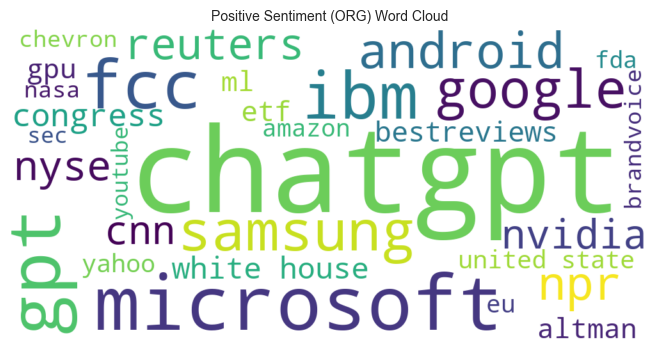

In [28]:
fig = plt.figure()
figsize = (18, 12)
plt.imshow(wordCloud(news_processed[news_processed['vader_sentiment'] == 'positive']['entity_org'], 
                     count=200), interpolation = 'bilinear')
plt.title('Positive Sentiment (ORG) Word Cloud', fontsize=10)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

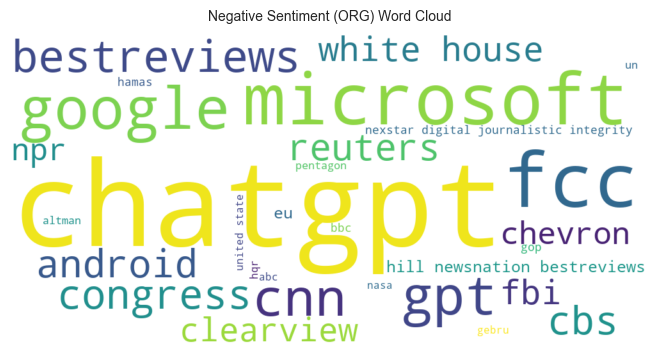

In [29]:
fig = plt.figure()
figsize = (18, 12)
plt.imshow(wordCloud(news_processed[news_processed['vader_sentiment'] == 'negative']['entity_org'], 
                     count=200), interpolation = 'bilinear')
plt.title('Negative Sentiment (ORG) Word Cloud', fontsize=10)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 4. Identify top candidates for AI integration - these can be related to any industry and yield positive or negative results (sentiment analysis).
- Suggest why certain types of jobs are more likely to be impacted by AI
- Plot a timeline to illustrate how the sentiment is changing over time

#### Entity (ORG)

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner(df, col):
    # Function to count entities for a given year
    def count_entities(df, year, entity_column):
        year_df = df[df['year'] == year]
        all_entities = [entity for sublist in year_df[entity_column].dropna() for entity in sublist]
        return dict(Counter(all_entities))
    
    # Initialize a dictionary to store counts by year and entity type
    entity_counts_by_year = defaultdict(lambda: defaultdict(Counter))
    
    # Count entities for each year and entity type
    for index, row in df.iterrows():
        year = row['year']
        for entity_type in ['entity_person', 'entity_org', 'entity_location']:
            entities = row[entity_type]
            if entities:
                entity_counts_by_year[year][entity_type].update(entities)
    
    # Convert defaultdict to a regular dict for easier viewing
    entity_counts_by_year = {year: dict(types) for year, types in entity_counts_by_year.items()}
    
    # Create a DataFrame for a given year
    def create_df_for_year(year, entity_counts_by_year):
        data = [
            {'entity_type': entity_type, 'entity': entity, 'count': count}
            for entity_type, entities in entity_counts_by_year[year].items()
            for entity, count in entities.items()
        ]
        return pd.DataFrame(data)
    
    # Create separate DataFrames for each year
    news_data = {}
    for year in range(2020, 2025):  # Including 2024
        news_data[year] = create_df_for_year(year, entity_counts_by_year)
    
    # Get top 200 entities per type per year
    entity_types = ['entity_org', 'entity_person', 'entity_location']
    top_entities = {}
    for year, df_year in news_data.items():
        top_entities[year] = {
            entity_type: df_year[df_year['entity_type'] == entity_type]
            .sort_values('count', ascending=False)
            .head(200)
            .reset_index(drop=True)
            for entity_type in entity_types
        }
    
    
   # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Get counts for key entities
    def get_counts(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        counts = filtered_df.groupby('entity')['count'].sum()
        counts.name = year
        return counts
    
    # Process each year for the specified entity type
    combined_counts = pd.concat([
        get_counts(normalize_entities(pd.DataFrame(top_entities[year][col]), col), year, col)
        for year in range(2020, 2025)  # Including 2024
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_counts = combined_counts.reset_index().rename(columns={'index': 'entity'})
    
    # Sum counts across all years
    combined_counts['total_count'] = combined_counts.iloc[:, 1:].sum(axis=1)
    
    # Sort by total count
    combined_counts_sorted = combined_counts.sort_values(by='total_count', ascending=False)
    
    # Plotting the data (combined total count for all years)
    plt.figure(figsize=(15, 10))
    sns.barplot(
        data=combined_counts_sorted, x='entity', y='total_count', palette='viridis'
    )
    
    # Enhancing the plot
    plt.title('Total Count of {} Across All Years'.format(col))
    plt.xlabel('Entity')
    plt.ylabel('Total Count')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


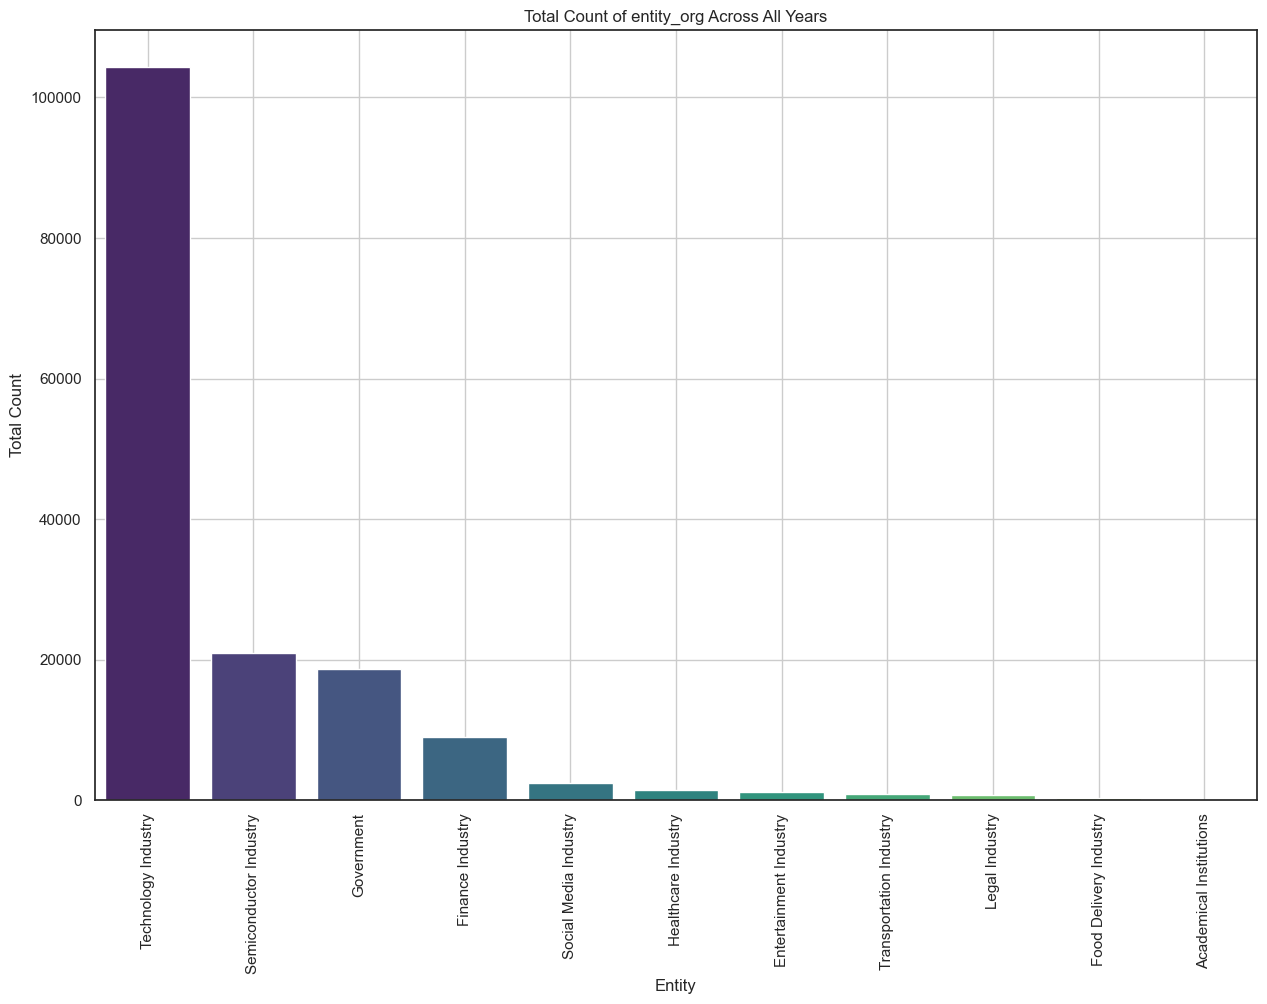

CPU times: user 5.28 s, sys: 131 ms, total: 5.41 s
Wall time: 5.23 s


In [58]:
%%time
plot_ner(news_processed[news_processed['vader_sentiment'] == 'positive'], 'entity_org')

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner_postive(df, col):
    # Function to get sentiment data for a given year
    def get_sentiment_data(df, year, entity_column):
        year_df = df[df['year'] == year]
        sentiment_data = []
        for index, row in year_df.iterrows():
            entities = row[entity_column]
            sentiment = row['vader_positive']
            if entities:
                for entity in entities:
                    sentiment_data.append({'entity': entity, 'sentiment': sentiment})
        return pd.DataFrame(sentiment_data)
    
    # Initialize a dictionary to store sentiment data by year and entity type
    sentiment_data_by_year = defaultdict(pd.DataFrame)
    
    # Collect sentiment data for each year and entity type
    for year in range(2020, 2025):  # Including 2024
        sentiment_data_by_year[year] = get_sentiment_data(df, year, col)
    
    # Aggregate sentiment data
    def aggregate_sentiment(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        sentiment_avg = filtered_df.groupby('entity')['sentiment'].mean()
        sentiment_avg.name = year
        return sentiment_avg
    
  # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Process each year for the specified entity type
    combined_sentiment = pd.concat([
        aggregate_sentiment(normalize_entities(sentiment_data_by_year[year], col), year, col)
        for year in range(2020, 2025)  # Including 2024
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_sentiment = combined_sentiment.reset_index().rename(columns={'index': 'entity'})
    
    # Compute average sentiment across all years
    combined_sentiment['average_sentiment'] = combined_sentiment.iloc[:, 1:].mean(axis=1)
    
    # Sort by average sentiment
    combined_sentiment_sorted = combined_sentiment.sort_values(by='average_sentiment', ascending=False)
    
    # Plotting the data (average sentiment across all years)
    plt.figure(figsize=(15, 10))
    barplot = sns.barplot(
        data=combined_sentiment_sorted, x='entity', y='average_sentiment'
    )

    # Enhancing the plot
    plt.title('Average Positive Sentiment of {} Across All Years'.format(col))
    plt.xlabel('Entity')
    plt.ylabel('Average Positive Sentiment')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


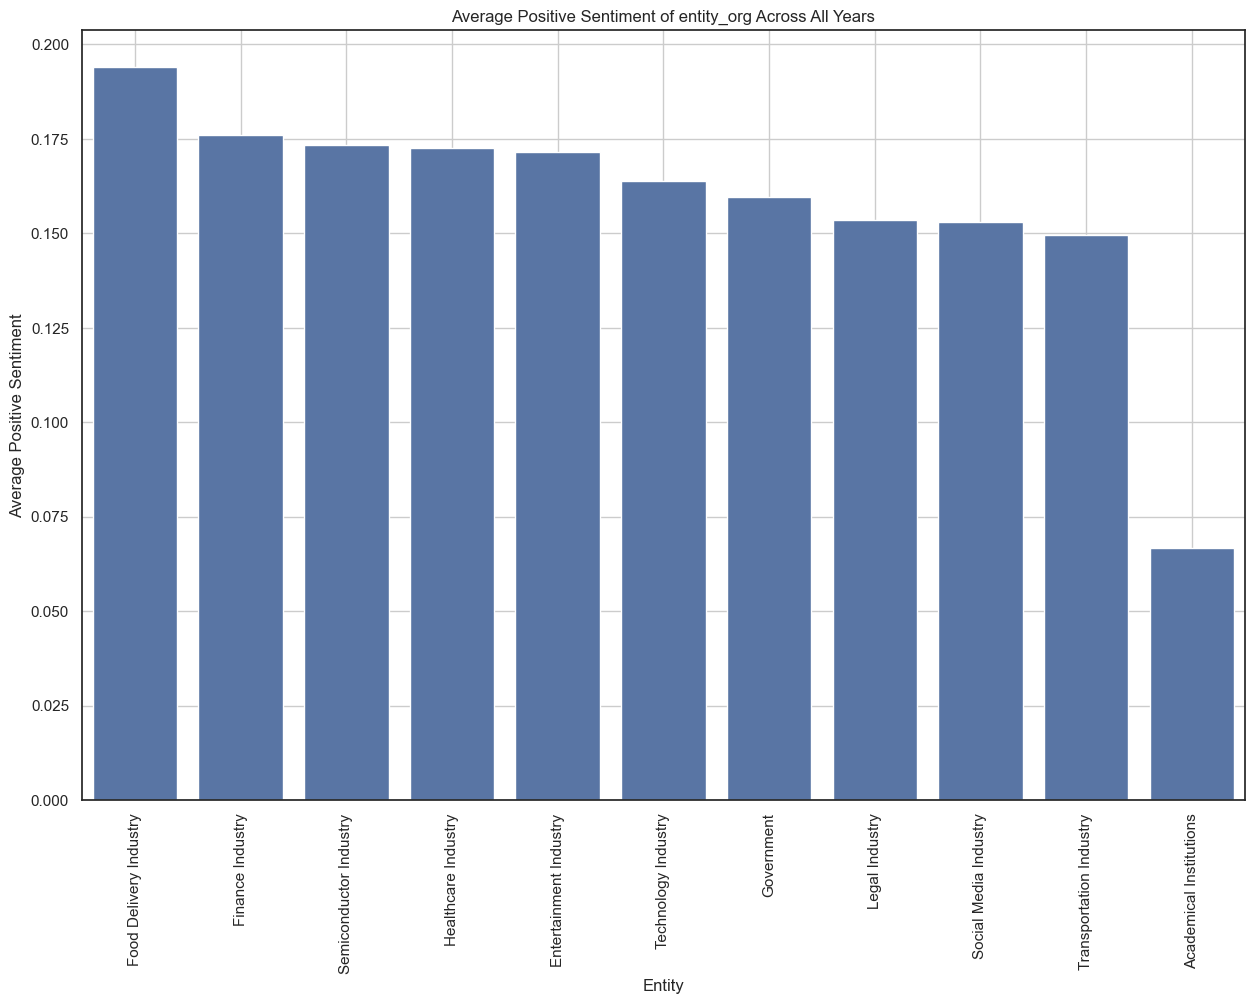

CPU times: user 11.9 s, sys: 278 ms, total: 12.2 s
Wall time: 12.1 s


In [60]:
%%time
plot_ner_postive(news_processed[news_processed['vader_sentiment'] == 'positive'], 'entity_org')

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner_negative(df, col):
    # Function to get sentiment data for a given year
    def get_sentiment_data(df, year, entity_column):
        year_df = df[df['year'] == year]
        sentiment_data = []
        for index, row in year_df.iterrows():
            entities = row[entity_column]
            sentiment = -row['vader_negative']
            if entities:
                for entity in entities:
                    sentiment_data.append({'entity': entity, 'sentiment': sentiment})
        return pd.DataFrame(sentiment_data)
    
    # Initialize a dictionary to store sentiment data by year and entity type
    sentiment_data_by_year = defaultdict(pd.DataFrame)
    
    # Collect sentiment data for each year and entity type
    for year in range(2020, 2025):  # Including 2024
        sentiment_data_by_year[year] = get_sentiment_data(df, year, col)
    
    # Aggregate sentiment data
    def aggregate_sentiment(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        sentiment_avg = filtered_df.groupby('entity')['sentiment'].mean()
        sentiment_avg.name = year
        return sentiment_avg
    
  # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Process each year for the specified entity type
    combined_sentiment = pd.concat([
        aggregate_sentiment(normalize_entities(sentiment_data_by_year[year], col), year, col)
        for year in range(2020, 2025)  # Including 2024
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_sentiment = combined_sentiment.reset_index().rename(columns={'index': 'entity'})
    
    # Compute average sentiment across all years
    combined_sentiment['average_sentiment'] = combined_sentiment.iloc[:, 1:].mean(axis=1)
    
    # Sort by average sentiment
    combined_sentiment_sorted = combined_sentiment.sort_values(by='average_sentiment', ascending=False)
    
    # Plotting the data (average sentiment across all years)
    plt.figure(figsize=(15, 10))
    barplot = sns.barplot(
        data=combined_sentiment_sorted, x='entity', y='average_sentiment'
    )

    # Enhancing the plot
    plt.title('Average Negative Sentiment of {} Across All Years'.format(col))
    plt.xlabel('Entity')
    plt.ylabel('Average Negative Sentiment')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


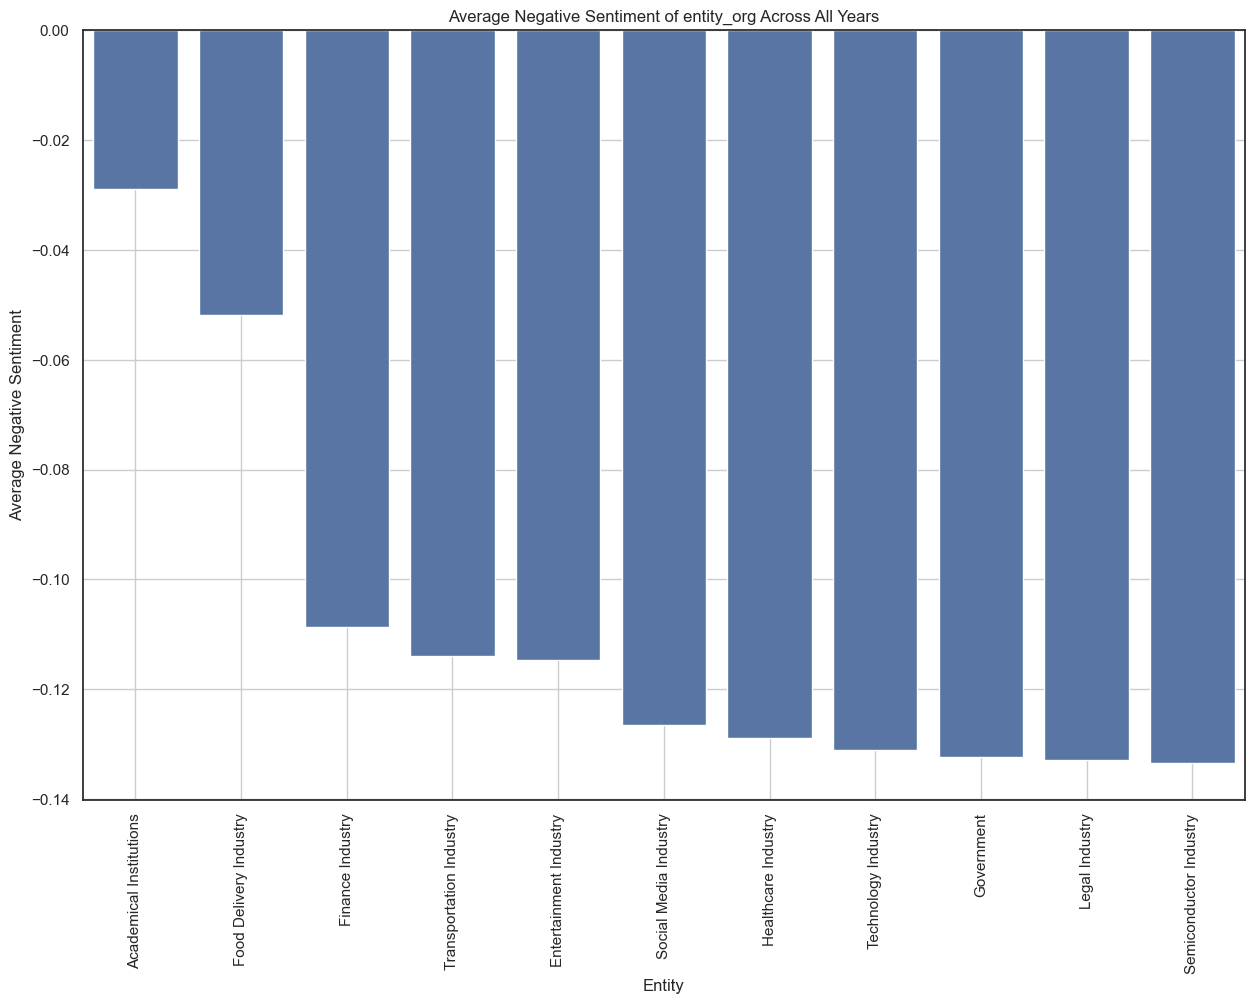

CPU times: user 770 ms, sys: 81.7 ms, total: 851 ms
Wall time: 647 ms


In [62]:
%%time
plot_ner_negative(news_processed[news_processed['vader_sentiment'] == 'negative'], 'entity_org')

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner_time(df, col):
    # Function to count entities for a given year
    def count_entities(df, year, entity_column):
        year_df = df[df['year'] == year]
        all_entities = [entity for sublist in year_df[entity_column].dropna() for entity in sublist]
        return dict(Counter(all_entities))
    
    # Initialize a dictionary to store counts by year and entity type
    entity_counts_by_year = defaultdict(lambda: defaultdict(Counter))
    
    # Count entities for each year and entity type
    for index, row in df.iterrows():
        year = row['year']
        for entity_type in ['entity_person', 'entity_org', 'entity_location']:
            entities = row[entity_type]
            if entities:
                entity_counts_by_year[year][entity_type].update(entities)
    
    # Convert defaultdict to a regular dict for easier viewing
    entity_counts_by_year = {year: dict(types) for year, types in entity_counts_by_year.items()}
    
    # Create a DataFrame for a given year
    def create_df_for_year(year, entity_counts_by_year):
        data = [
            {'entity_type': entity_type, 'entity': entity, 'count': count}
            for entity_type, entities in entity_counts_by_year[year].items()
            for entity, count in entities.items()
        ]
        return pd.DataFrame(data)
    
    # Create separate DataFrames for each year
    news_data = {}
    for year in range(2020, 2025): 
        news_data[year] = create_df_for_year(year, entity_counts_by_year)
    
    # Get top 200 entities per type per year
    entity_types = ['entity_org', 'entity_person', 'entity_location']
    top_entities = {}
    for year, df_year in news_data.items():
        top_entities[year] = {
            entity_type: df_year[df_year['entity_type'] == entity_type]
            .sort_values('count', ascending=False)
            .head(200)
            .reset_index(drop=True)
            for entity_type in entity_types
        }
    
  # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Get counts for key entities
    def get_counts(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        counts = filtered_df.groupby('entity')['count'].sum()
        counts.name = year
        return counts
    
    # Process each year for the specified entity type
    combined_counts = pd.concat([
        get_counts(normalize_entities(pd.DataFrame(top_entities[year][col]), col), year, col)
        for year in range(2020, 2025)  
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_counts = combined_counts.reset_index().rename(columns={'index': 'entity'})
    
    # Melt the DataFrame for plotting
    combined_counts_melted = combined_counts.melt(
        id_vars=['entity'], var_name='year', value_name='count'
    )
    
    # Sort entities by their count in 2024
    entities_sorted_by_2024 = combined_counts.sort_values(by=2024, ascending=False)['entity']
    
    # Plotting the data
    plt.figure(figsize=(15, 10))
    sns.lineplot(
        data=combined_counts_melted, x='year', y='count', hue='entity',
        hue_order=entities_sorted_by_2024, marker='o'
    )
    
    # Enhancing the plot
    plt.title('Count of {} Over Time'.format(col))
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend(title='Entity', bbox_to_anchor=(1.01, 1.01), loc='upper left')
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


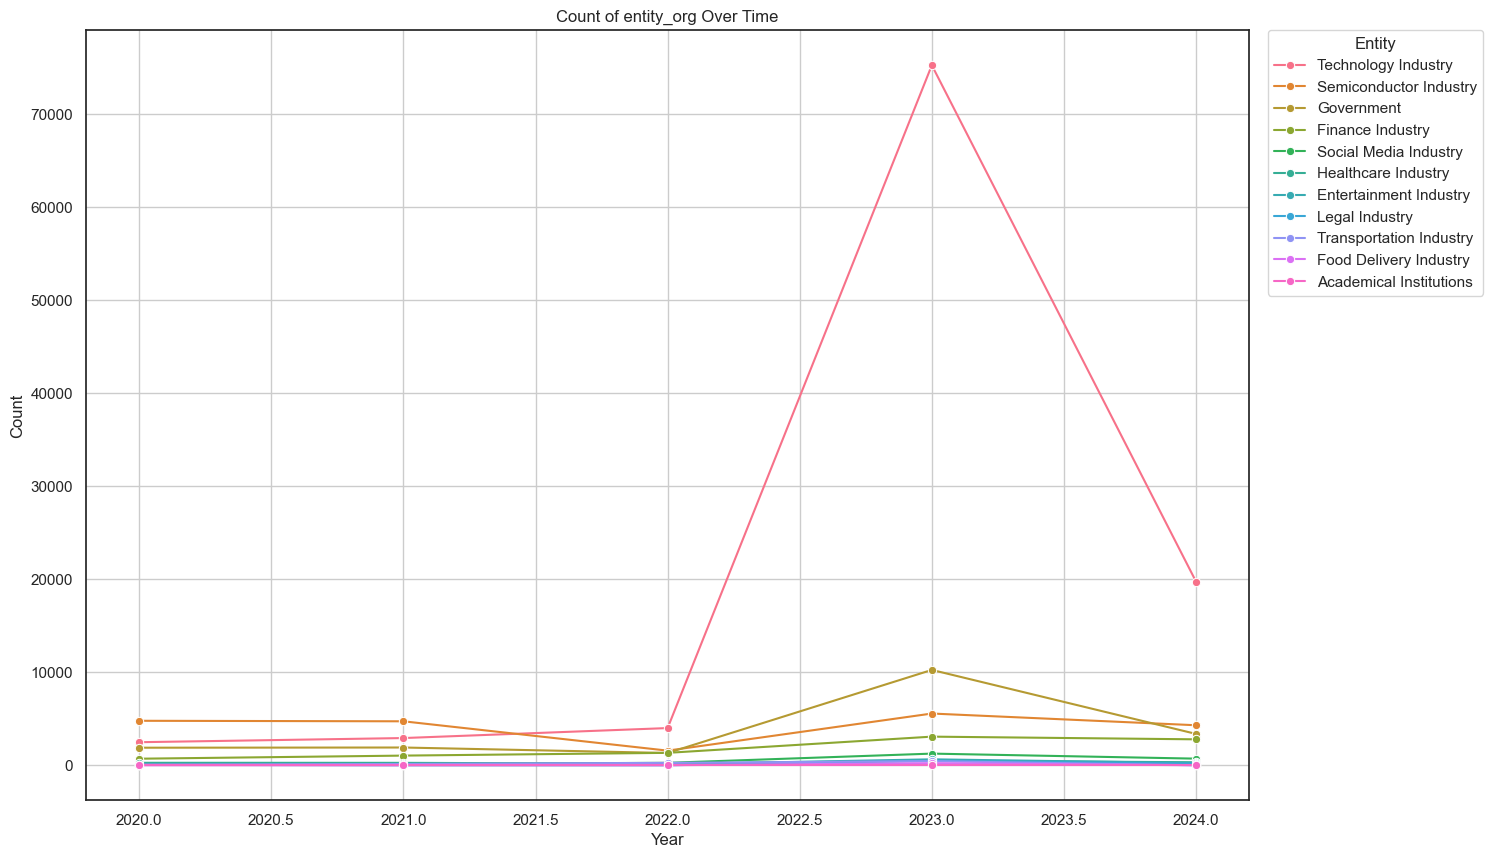

CPU times: user 5.44 s, sys: 117 ms, total: 5.56 s
Wall time: 5.59 s


In [64]:
%%time
plot_ner_time(news_processed[news_processed['vader_sentiment'] == 'positive'], 'entity_org')

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_ner_time_sentiment(df, col):
    # Function to get positive sentiment data for a given year
    def get_sentiment_data(df, year, entity_column):
        year_df = df[df['year'] == year]
        sentiment_data = []
        for index, row in year_df.iterrows():
            entities = row[entity_column]
            sentiment = row['vader_positive']
            if entities:
                for entity in entities:
                    sentiment_data.append({'entity': entity, 'sentiment': sentiment})
        return pd.DataFrame(sentiment_data)
    
    # Initialize a dictionary to store sentiment data by year and entity type
    sentiment_data_by_year = defaultdict(pd.DataFrame)
    
    # Collect sentiment data for each year and entity type
    for year in range(2020, 2025):  # Including 2024
        sentiment_data_by_year[year] = get_sentiment_data(df, year, col)
    
    # Aggregate sentiment data
    def aggregate_sentiment(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        sentiment_avg = filtered_df.groupby('entity')['sentiment'].mean()
        sentiment_avg.name = year
        return sentiment_avg
    
   # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Process each year for the specified entity type
    combined_sentiment = pd.concat([
        aggregate_sentiment(normalize_entities(sentiment_data_by_year[year], col), year, col)
        for year in range(2020, 2025)  
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_sentiment = combined_sentiment.reset_index().rename(columns={'index': 'entity'})
    
    # Melt the DataFrame for plotting
    combined_sentiment_melted = combined_sentiment.melt(
        id_vars=['entity'], var_name='year', value_name='sentiment'
    )
    
    # Sort entities by their sentiment in 2024
    entities_sorted_by_2024 = combined_sentiment.sort_values(by=2024, ascending=False)['entity']
    
    # Plotting the data
    plt.figure(figsize=(15, 10))
    sns.lineplot(
        data=combined_sentiment_melted, x='year', y='sentiment', hue='entity',
        hue_order=entities_sorted_by_2024, marker='o'
    )
    
    # Enhancing the plot
    plt.title('Average Positive Sentiment of {} Over Time'.format(col))
    plt.xlabel('Year')
    plt.ylabel('Average Positive Sentiment')
    plt.legend(title='Entity', bbox_to_anchor=(1.01, 1.01), loc='upper left')
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner_sentiment(df_news, 'entity_org')  # For organizations
# plot_ner_sentiment(df_news, 'entity_person')  # For persons
# plot_ner_sentiment(df_news, 'entity_location')  # For locations


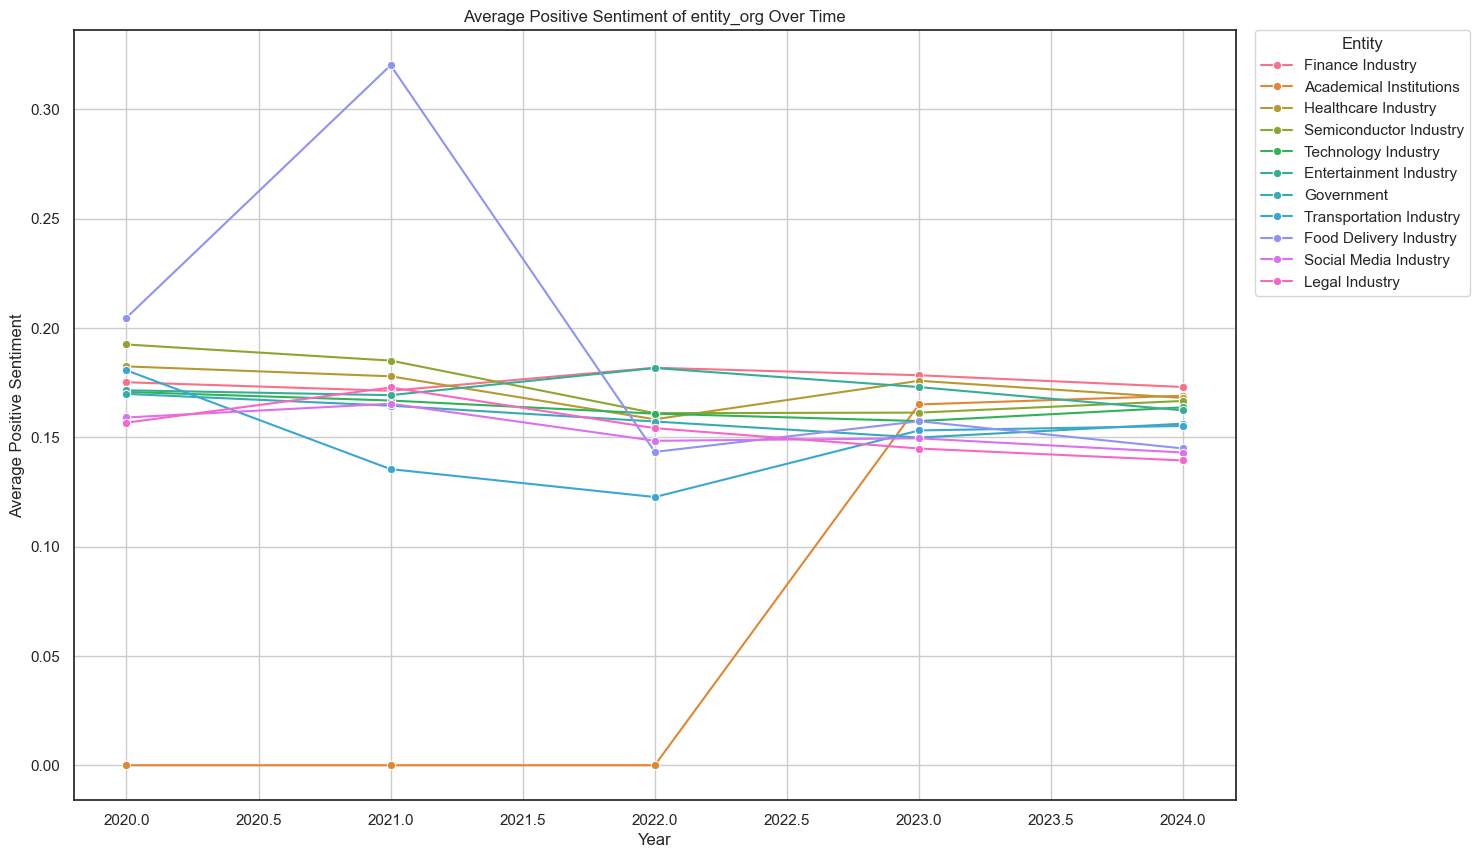

CPU times: user 13.1 s, sys: 314 ms, total: 13.4 s
Wall time: 13.3 s


In [66]:
%%time
plot_ner_time_sentiment(news_processed[news_processed['vader_sentiment'] == 'positive'], 'entity_org')

#### Entity (LOCATION)

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner(df, col):
    # Function to count entities for a given year
    def count_entities(df, year, entity_column):
        year_df = df[df['year'] == year]
        all_entities = [entity for sublist in year_df[entity_column].dropna() for entity in sublist]
        return dict(Counter(all_entities))
    
    # Initialize a dictionary to store counts by year and entity type
    entity_counts_by_year = defaultdict(lambda: defaultdict(Counter))
    
    # Count entities for each year and entity type
    for index, row in df.iterrows():
        year = row['year']
        for entity_type in ['entity_person', 'entity_org', 'entity_location']:
            entities = row[entity_type]
            if entities:
                entity_counts_by_year[year][entity_type].update(entities)
    
    # Convert defaultdict to a regular dict for easier viewing
    entity_counts_by_year = {year: dict(types) for year, types in entity_counts_by_year.items()}
    
    # Create a DataFrame for a given year
    def create_df_for_year(year, entity_counts_by_year):
        data = [
            {'entity_type': entity_type, 'entity': entity, 'count': count}
            for entity_type, entities in entity_counts_by_year[year].items()
            for entity, count in entities.items()
        ]
        return pd.DataFrame(data)
    
    # Create separate DataFrames for each year
    news_data = {}
    for year in range(2020, 2025):  # Including 2024
        news_data[year] = create_df_for_year(year, entity_counts_by_year)
    
    # Get top 200 entities per type per year
    entity_types = ['entity_org', 'entity_person', 'entity_location']
    top_entities = {}
    for year, df_year in news_data.items():
        top_entities[year] = {
            entity_type: df_year[df_year['entity_type'] == entity_type]
            .sort_values('count', ascending=False)
            .head(200)
            .reset_index(drop=True)
            for entity_type in entity_types
        }
    
    
    # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            'legal': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Get counts for key entities
    def get_counts(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        counts = filtered_df.groupby('entity')['count'].sum()
        counts.name = year
        return counts
    
    # Process each year for the specified entity type
    combined_counts = pd.concat([
        get_counts(normalize_entities(pd.DataFrame(top_entities[year][col]), col), year, col)
        for year in range(2020, 2025)  # Including 2024
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_counts = combined_counts.reset_index().rename(columns={'index': 'entity'})
    
    # Sum counts across all years
    combined_counts['total_count'] = combined_counts.iloc[:, 1:].sum(axis=1)
    
    # Sort by total count
    combined_counts_sorted = combined_counts.sort_values(by='total_count', ascending=False)
    
    # Plotting the data (combined total count for all years)
    plt.figure(figsize=(15, 10))
    sns.barplot(
        data=combined_counts_sorted, x='entity', y='total_count', palette='viridis'
    )
    
    # Enhancing the plot
    plt.title('Total Count of {} Across All Years'.format(col))
    plt.xlabel('Entity')
    plt.ylabel('Total Count')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


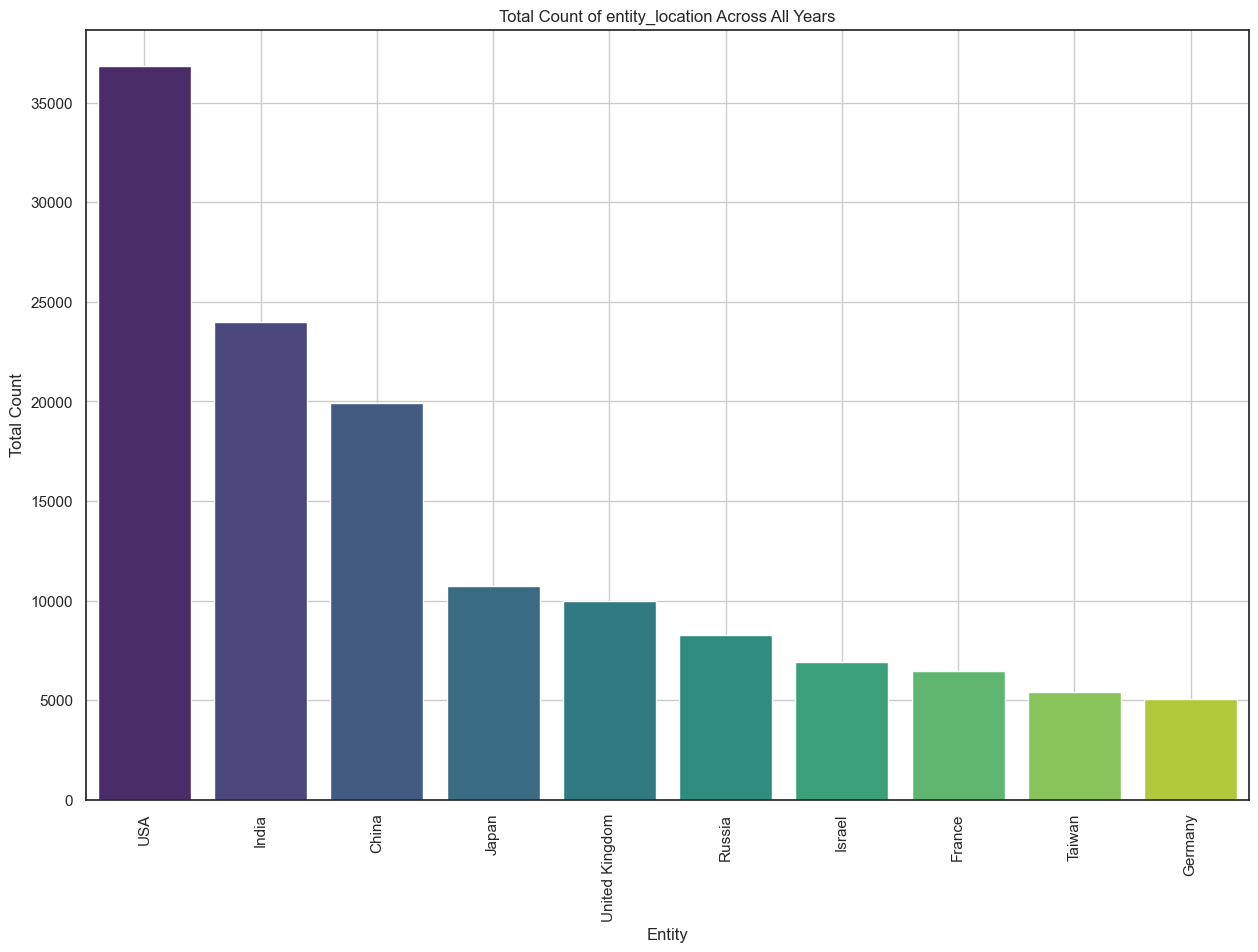

CPU times: user 4.4 s, sys: 109 ms, total: 4.51 s
Wall time: 4.37 s


In [42]:
%%time
plot_ner(news_processed[news_processed['vader_sentiment'] == 'positive'], 'entity_location')

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner_postive(df, col):
    # Function to get sentiment data for a given year
    def get_sentiment_data(df, year, entity_column):
        year_df = df[df['year'] == year]
        sentiment_data = []
        for index, row in year_df.iterrows():
            entities = row[entity_column]
            sentiment = row['vader_positive']
            if entities:
                for entity in entities:
                    sentiment_data.append({'entity': entity, 'sentiment': sentiment})
        return pd.DataFrame(sentiment_data)
    
    # Initialize a dictionary to store sentiment data by year and entity type
    sentiment_data_by_year = defaultdict(pd.DataFrame)
    
    # Collect sentiment data for each year and entity type
    for year in range(2020, 2025):  # Including 2024
        sentiment_data_by_year[year] = get_sentiment_data(df, year, col)
    
    # Aggregate sentiment data
    def aggregate_sentiment(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        sentiment_avg = filtered_df.groupby('entity')['sentiment'].mean()
        sentiment_avg.name = year
        return sentiment_avg
    
  # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            'legal': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Process each year for the specified entity type
    combined_sentiment = pd.concat([
        aggregate_sentiment(normalize_entities(sentiment_data_by_year[year], col), year, col)
        for year in range(2020, 2025)  # Including 2024
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_sentiment = combined_sentiment.reset_index().rename(columns={'index': 'entity'})
    
    # Compute average sentiment across all years
    combined_sentiment['average_sentiment'] = combined_sentiment.iloc[:, 1:].mean(axis=1)
    
    # Sort by average sentiment
    combined_sentiment_sorted = combined_sentiment.sort_values(by='average_sentiment', ascending=False)
    
    # Plotting the data (average sentiment across all years)
    plt.figure(figsize=(15, 10))
    barplot = sns.barplot(
        data=combined_sentiment_sorted, x='entity', y='average_sentiment'
    )

    # Enhancing the plot
    plt.title('Average Positive Sentiment of {} Across All Years'.format(col))
    plt.xlabel('Entity')
    plt.ylabel('Average Positive Sentiment')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


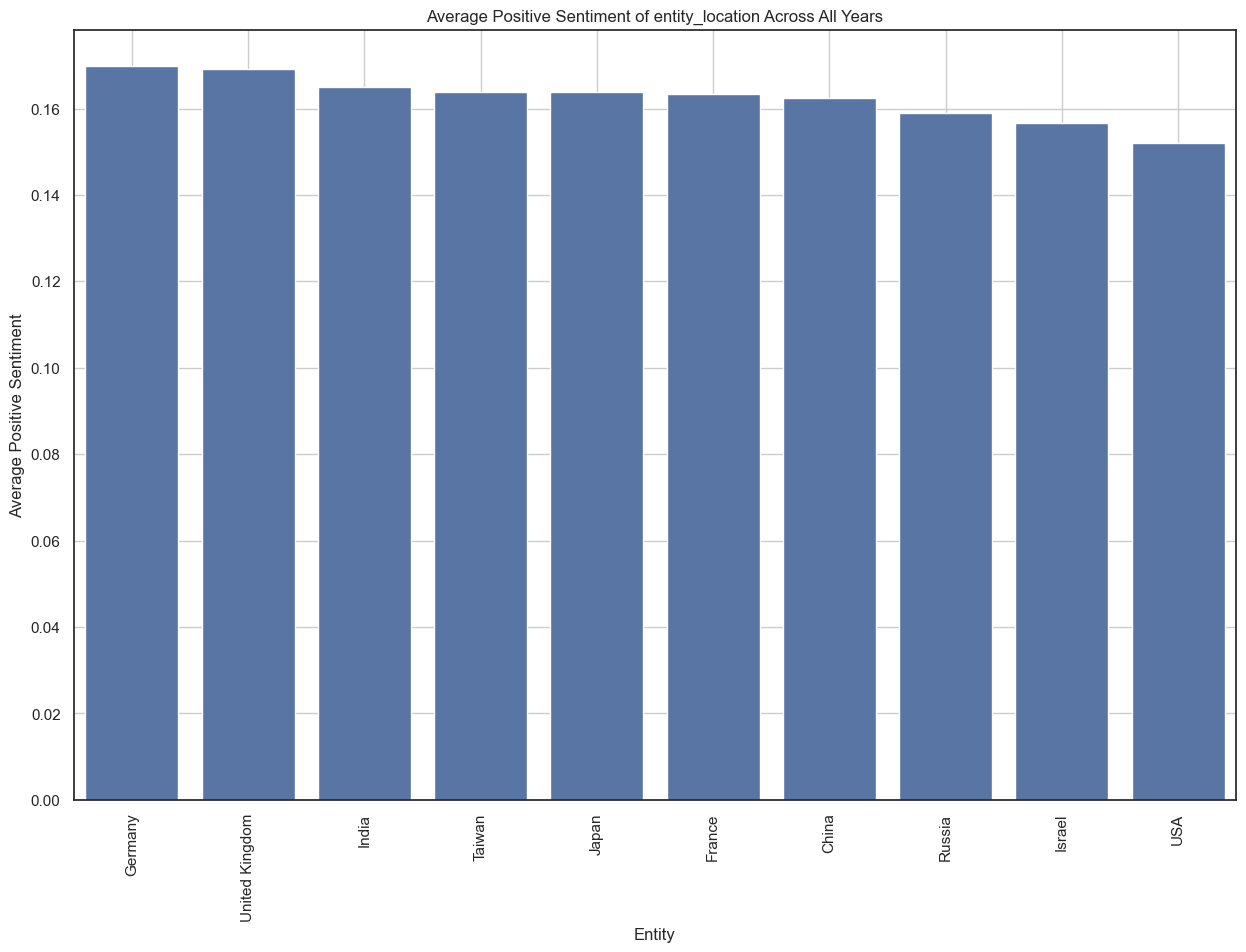

CPU times: user 4.31 s, sys: 113 ms, total: 4.42 s
Wall time: 4.22 s


In [44]:
%%time
plot_ner_postive(news_processed[news_processed['vader_sentiment'] == 'positive'], 'entity_location')

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def plot_ner_negative(df, col):
    # Function to get sentiment data for a given year
    def get_sentiment_data(df, year, entity_column):
        year_df = df[df['year'] == year]
        sentiment_data = []
        for index, row in year_df.iterrows():
            entities = row[entity_column]
            sentiment = -row['vader_negative']
            if entities:
                for entity in entities:
                    sentiment_data.append({'entity': entity, 'sentiment': sentiment})
        return pd.DataFrame(sentiment_data)
    
    # Initialize a dictionary to store sentiment data by year and entity type
    sentiment_data_by_year = defaultdict(pd.DataFrame)
    
    # Collect sentiment data for each year and entity type
    for year in range(2020, 2025):  # Including 2024
        sentiment_data_by_year[year] = get_sentiment_data(df, year, col)
    
    # Aggregate sentiment data
    def aggregate_sentiment(df, year, col):
        filtered_df = df[df['entity'].isin(key_entities[col])]
        sentiment_avg = filtered_df.groupby('entity')['sentiment'].mean()
        sentiment_avg.name = year
        return sentiment_avg
    
  # Mapping for name normalization
    mapping = {
        'entity_org': {
            
            'financial glossary': 'Finance Industry',
            'morgan stanley': 'Finance Industry',
            'goldman sachs': 'Finance Industry',
            'zacks': 'Finance Industry',
            'etf': 'Finance Industry',
            'buy': 'Finance Industry',
            'price': 'Finance Industry',
            'nyse': 'Finance Industry',
            'nasdaq': 'Finance Industry',
            'earnings': 'Finance Industry',
            'fintech': 'Finance Industry',
            
            'medical': 'Healthcare Industry',
            'health': 'Healthcare Industry',
            'healthcare': 'Healthcare Industry',
            'cancer': 'Healthcare Industry',
            'covid': 'Healthcare Industry',
            'insurance': 'Healthcare Industry',
            'health insurance': 'Healthcare Industry',
            
            'facebook': 'Social Media Industry',
            'linkedin': 'Social Media Industry',
            'twitter': 'Social Media Industry',
            'whatsapp': 'Social Media Industry',
            'snap': 'Social Media Industry',
            'insta': 'Social Media Industry',
            'instagram': 'Social Media Industry',
            'youtube': 'Social Media Industry',
            
            'congress': 'Government',
            'government': 'Government',
            'white house': 'Government',
            'ccp': 'Government',
            'united state': 'Government',
            'palantir': 'Government',
            'senate': 'Government', 
            'nasa': 'Government',
            'pentagon': 'Government',
            'eu': 'Government',
            'bjp': 'Government',
            
            'court': 'Legal Industry',
            'law': 'Legal Industry',
            'legal': 'Legal Industry',
            'fbi': 'Legal Industry',
            'rule': 'Legal Industry',
            'case': 'Legal Industry',
            'gordon legal': 'Legal Industry',
            
            'nvidia': 'Semiconductor Industry',  
            'intel': 'Semiconductor Industry', 
            'intel corporation': 'Semiconductor Industry',
            'amd': 'Semiconductor Industry', 
            'chip': 'Semiconductor Industry', 
            'gpu': 'Semiconductor Industry', 
            'cpu': 'Semiconductor Industry',
            'tsmc': 'Semiconductor Industry',
            'semiconductor': 'Semiconductor Industry',
            'tpu': 'Semiconductor Industry',
            'apple': 'Semiconductor Industry',
            'tesla': 'Semiconductor Industry',
            'ibm': 'Semiconductor Industry',
            
            'aws': 'Technology Industry', 
            'android': 'Technology Industry', 
            'ai': 'Technology Industry', 
            'ml': 'Technology Industry', 
            'google': 'Technology Industry', 
            'microsoft': 'Technology Industry',
            'bard': 'Technology Industry',
            'openai': 'Technology Industry',
            'chatgpt': 'Technology Industry',
            'gpt': 'Technology Industry',
            'gemini': 'Technology Industry',
            'bing': 'Technology Industry',
            'bing': 'Technology Industry',
            'google news': 'Technology Industry',
            'google deepmind': 'Technology Industry',
            
            'doordash': 'Food Delivery Industry',
            'instacart': 'Food Delivery Industry',
            'legal': 'Food Delivery Industry',
            
            'waymo': 'Transportation Industry',
            'ford': 'Transportation Industry',
            'argo ai': 'Transportation Industry',
            
            'walt disney': 'Entertainment Industry',
            'netflix': 'Entertainment Industry',
            'discovery': 'Entertainment Industry',
            
            'school authority': 'Academical Institutions',
            'mit harvard university': 'Academical Institutions'
            
        },
        'entity_person': {
            'Biden': 'Joe Biden',
            'Musk': 'Elon Musk', 
            'Trump': 'Donald Trump',
            'Pichai': 'Sundar Pichai', 
            'Zuckerberg': 'Mark Zuckerberg',
            'Bankman Fried': 'Sam Bankman Fried', 
            'Buffett': 'Warren Buffett',
            'Putin': 'Vladimir Putin', 
            'Huang': 'Jensen Huang', 
            'Timnit Gebru': 'Gebru'
        },
        'entity_location': {
            'united state': 'USA',
            'america': 'USA',
            'california': 'USA', 
            'florida': 'USA',
            'new york': 'USA',
            'ny': 'USA',
            'texas': 'USA',
            'russia': 'Russia', 
            'india': 'India',
            'china': 'China', 
            'israel': 'Israel', 
            'germany': 'Germany',
            'taiwan': 'Taiwan',
            'beijing': 'China',
            'france': 'France',
            'uk': 'United Kingdom',
            'united kingdom': 'United Kingdom',
            'london': 'United Kingdom',
            'japan': 'Japan',
            'tokyo': 'Japan'
        }
    }
    
    key_entities = {
        'entity_org': [
            'Semiconductor Industry', 'Technology Industry', 'Social Media Industry', 'Healthcare Industry', 
            'Finance Industry', 'Government', 'Legal Industry', 'Transportation Industry',
            'Entertainment Industry', 'Food Delivery Industry', 'Academical Institutions'
        ],
        'entity_person': [
            'Biden', 'Joe Biden', 'Elon Musk', 'Musk', 'Donald Trump', 'Trump', 'Gebru', 
            'Sundar Pichai', 'Pichai', 'Narendra Modi', 'Rebekah Jones', 'Mark Zuckerberg', 
            'Eric Schmidt', 'Bill Gates', 'Michael Kratsios', 'Frida Polli', 'Bankman Fried', 
            'Sam Bankman Fried', 'Zuckerberg', 'Warren Buffett', 'Buffett', 'Vladimir Putin', 
            'Putin', 'Sam Altman', 'Satya Nadella', 'Geoffrey Hinton', 'Jensen Huang', 'Huang', 
            'Steve Wozniak', 'Gary Marcus'
        ],
        'entity_location': [
            'USA', 'Russia', 'China', 'United Kingdom', 'Germany', 
            'France', 'India', 'Israel', 'Taiwan', 'Japan'
        ]
    }
    
    
    # Normalize entity names
    def normalize_entities(df, col):
        if col in mapping:
            df['entity'] = df['entity'].replace(mapping[col])
        return df
    
    # Process each year for the specified entity type
    combined_sentiment = pd.concat([
        aggregate_sentiment(normalize_entities(sentiment_data_by_year[year], col), year, col)
        for year in range(2020, 2025)  # Including 2024
    ], axis=1).fillna(0).reindex(key_entities[col], fill_value=0)
    
    # Ensure the 'entity' column is present
    combined_sentiment = combined_sentiment.reset_index().rename(columns={'index': 'entity'})
    
    # Compute average sentiment across all years
    combined_sentiment['average_sentiment'] = combined_sentiment.iloc[:, 1:].mean(axis=1)
    
    # Sort by average sentiment
    combined_sentiment_sorted = combined_sentiment.sort_values(by='average_sentiment', ascending=False)
    
    # Plotting the data (average sentiment across all years)
    plt.figure(figsize=(15, 10))
    barplot = sns.barplot(
        data=combined_sentiment_sorted, x='entity', y='average_sentiment'
    )

    # Enhancing the plot
    plt.title('Average Negative Sentiment of {} Across All Years'.format(col))
    plt.xlabel('Entity')
    plt.ylabel('Average Negative Sentiment')
    plt.xticks(rotation=90)
    plt.grid(True)
    
    # Show plot
    plt.show()

# Example usage:
# plot_ner(df_news, 'entity_org')  # For organizations
# plot_ner(df_news, 'entity_person')  # For persons
# plot_ner(df_news, 'entity_location')  # For locations


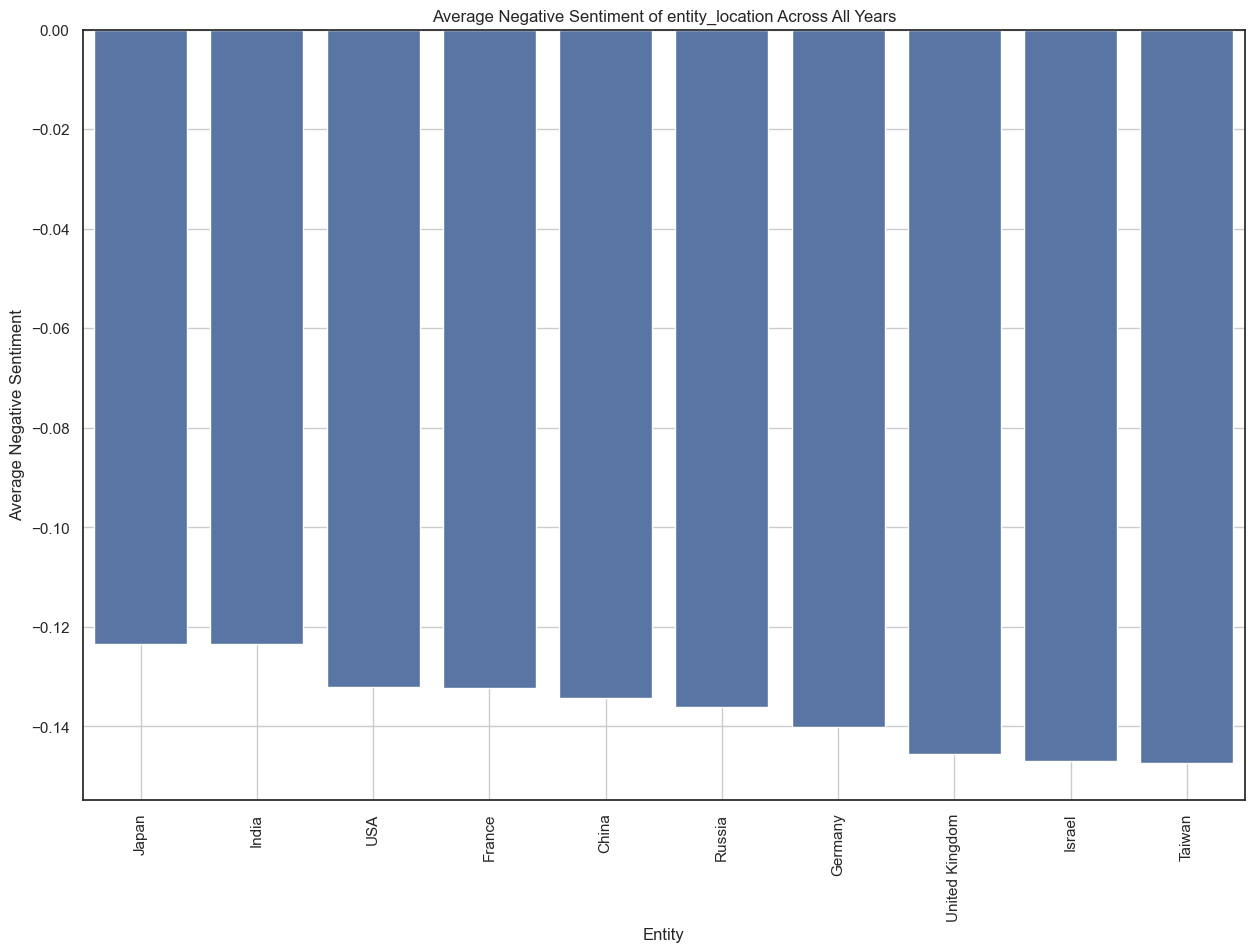

CPU times: user 567 ms, sys: 78.6 ms, total: 646 ms
Wall time: 442 ms


In [46]:
%%time
plot_ner_negative(news_processed[news_processed['vader_sentiment'] == 'negative'], 'entity_location')

### Leverage appropriate NLP techniques to identify organizations, people and locations, then apply targeted sentiment
- What types of companies (based on the lines of business) are planning to invest in these technologies today or near future (success stories)?
- What types of applications cannot currently be transformed by AI, based on today's state of technology (failures)?

#### Industry Comparison - Positive in Semiconductor vs Negative in Government

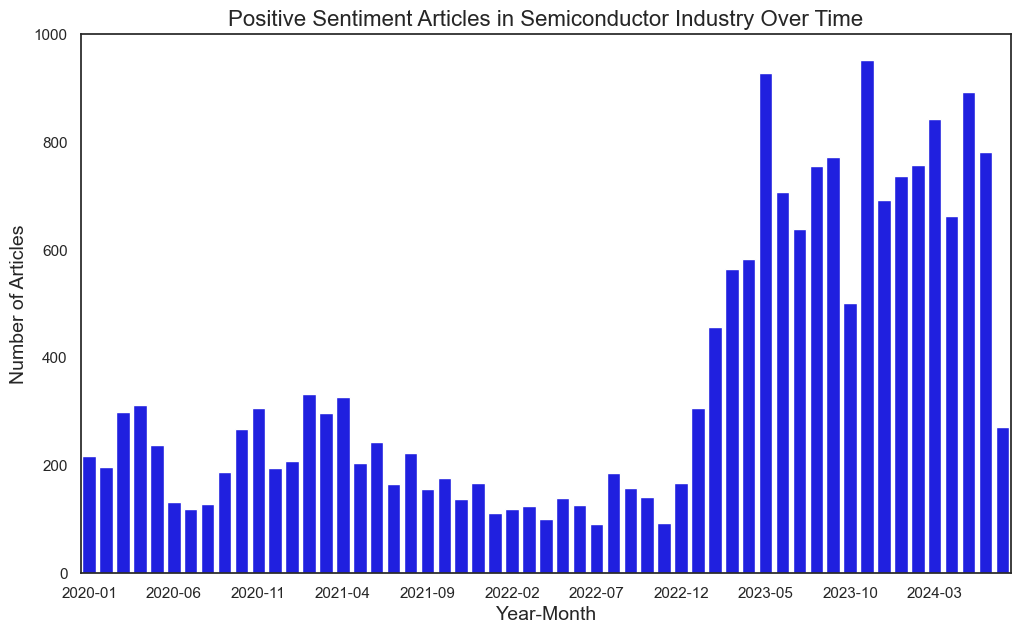

In [69]:
positive_industry_news = news_processed[(
    news_processed['vader_sentiment'] == 'positive') 
    & (news_processed['text_tokenized'].apply(lambda tokens: 
                                              'nvidia' in tokens 
                                              or 'intel' in tokens
                                              or 'amd' in tokens
                                              or 'chip' in tokens
                                              or 'gpu' in tokens
                                              or 'tsmc' in tokens
                                              or 'apple' in tokens
                                              or 'tesla' in tokens
                                              or 'ibm' in tokens
                                             ))][['year_month', 'vader_sentiment']]

# Count the number of positive sentiment articles per year-month
positive_counts = positive_industry_news['year_month'].value_counts().sort_index()


plt.figure(figsize=(12, 7))
sns.barplot(x=positive_counts.index, y=positive_counts.values, color='blue')
plt.title('Positive Sentiment Articles in Semiconductor Industry Over Time', fontsize=16)
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.ylim(0, 1000)
# Skip some xlabels
every_nth = 5  # Change this number to display every nth label
for n, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

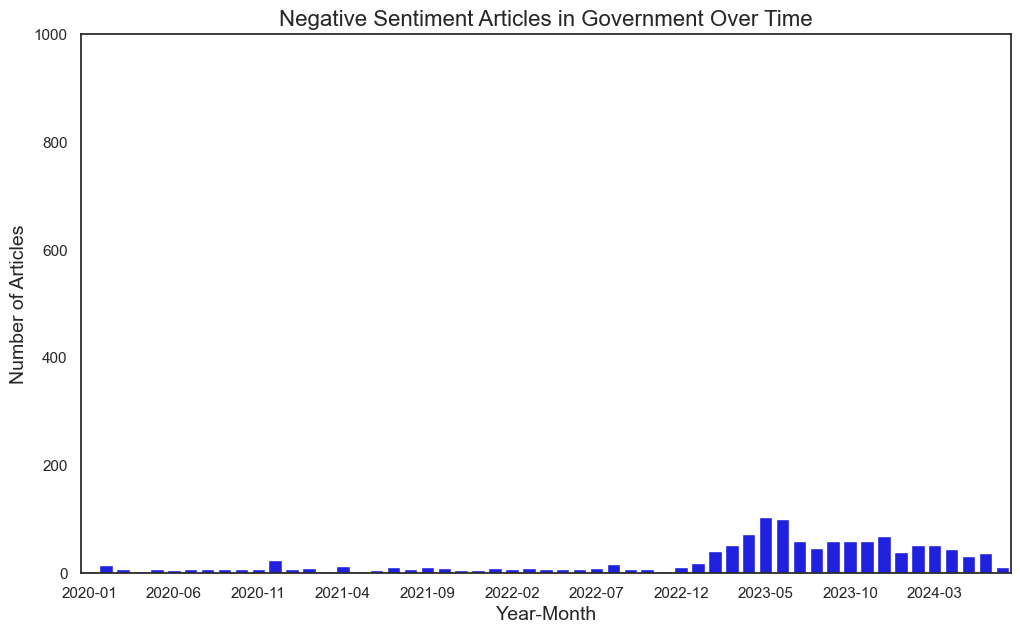

In [83]:
negative_industry_news = news_processed[(
    news_processed['vader_sentiment'] == 'negative') 
    & (news_processed['text_tokenized'].apply(lambda tokens: 
                                              'congress' in tokens 
                                              or 'government' in tokens
                                              or 'white house' in tokens
                                              or 'ccp' in tokens
                                              or 'palantir' in tokens
                                              or 'senate' in tokens
                                              or 'nasa' in tokens
                                              or 'pentagon' in tokens
                                              or 'eu' in tokens
                                              or 'bjp' in tokens
                                              or 'fbi' in tokens
                                             ))][['year_month', 'vader_sentiment']]

# Count the number of positive sentiment articles per year-month
negative_counts = negative_industry_news['year_month'].value_counts().sort_index()


plt.figure(figsize=(12, 7))
sns.barplot(x=negative_counts.index, y=negative_counts.values, color='blue')
plt.title('Negative Sentiment Articles in Government Over Time', fontsize=16)
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.ylim(0, 1000)
# Skip some xlabels
every_nth = 5  # Change this number to display every nth label
for n, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

#### Industry Comparison - Positive in Nvidia vs Positive in Intel

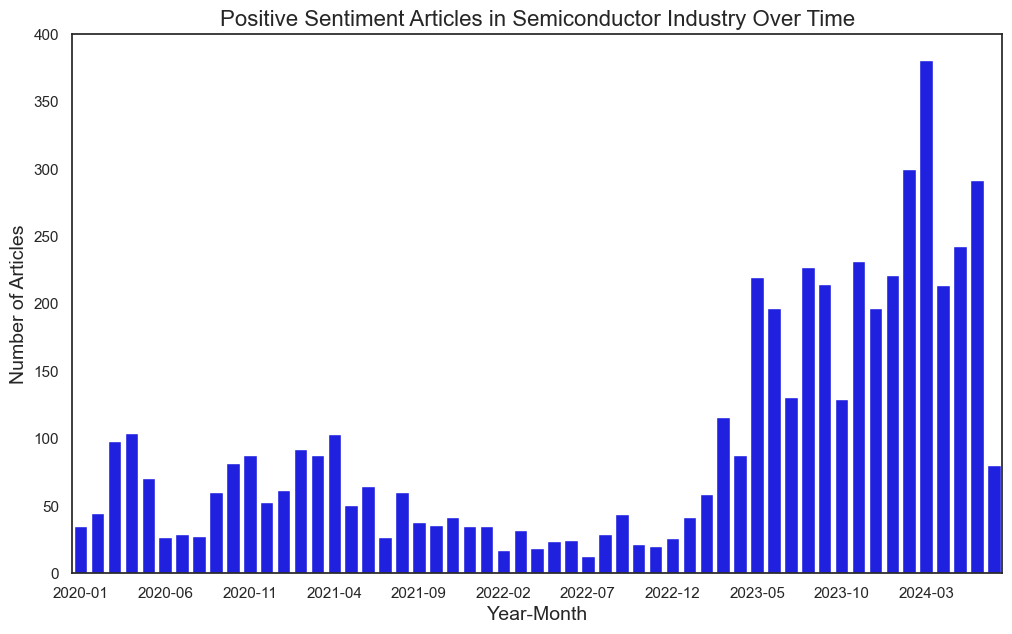

In [55]:
positive_industry_news = news_processed[(
    news_processed['vader_sentiment'] == 'positive') 
    & (news_processed['text_tokenized'].apply(lambda tokens: 'nvidia' in tokens))][['year_month', 'vader_sentiment']]

# Count the number of positive sentiment articles per year-month
positive_counts = positive_industry_news['year_month'].value_counts().sort_index()


plt.figure(figsize=(12, 7))
sns.barplot(x=positive_counts.index, y=positive_counts.values, color='blue')
plt.title('Positive Sentiment Articles in Semiconductor Industry Over Time', fontsize=16)
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.ylim(0, 400)
# Skip some xlabels
every_nth = 5  # Change this number to display every nth label
for n, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

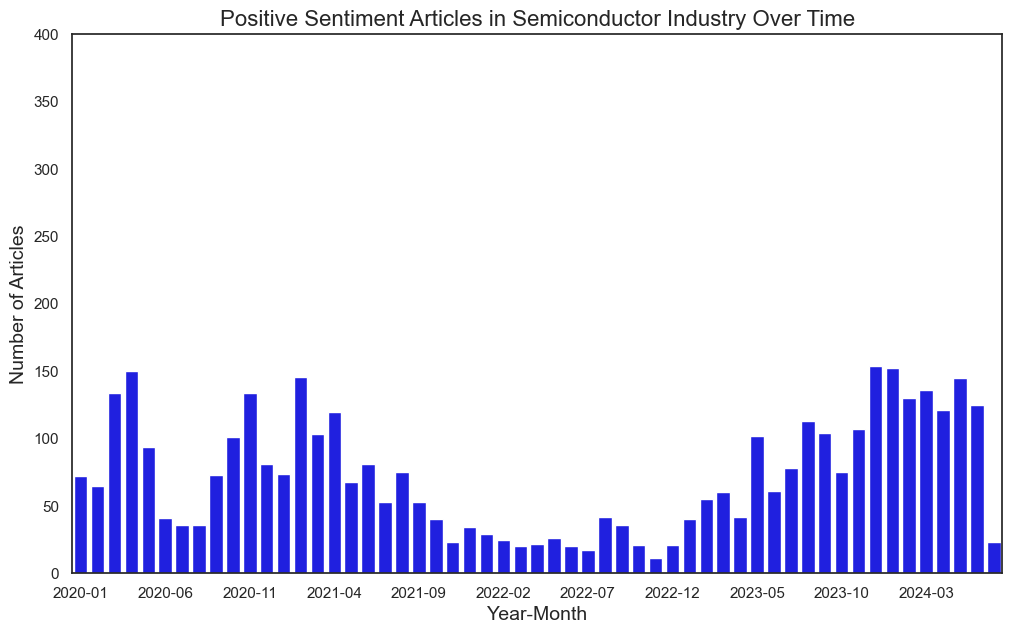

In [56]:
positive_industry_news = news_processed[(
    news_processed['vader_sentiment'] == 'positive') 
    & (news_processed['text_tokenized'].apply(lambda tokens: 'intel' in tokens))][['year_month', 'vader_sentiment']]

# Count the number of positive sentiment articles per year-month
positive_counts = positive_industry_news['year_month'].value_counts().sort_index()


plt.figure(figsize=(12, 7))
sns.barplot(x=positive_counts.index, y=positive_counts.values, color='blue')
plt.title('Positive Sentiment Articles in Semiconductor Industry Over Time', fontsize=16)
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.ylim(0, 400)
# Skip some xlabels
every_nth = 5  # Change this number to display every nth label
for n, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

In [84]:
# news_processed.to_parquet('news_processed_with_sentiment_entity.parquet')

In [52]:
# news_processed.to_csv('news_processed_with_sentiment_entity.csv', index=False)